In [1]:
import pandas as pd

# Load the dataset
file_path = 'bank-additional-full.csv'
data = pd.read_csv(file_path, sep=';')

# Display the first few rows of the dataset
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
print(f"Data before cleaning: {data.shape}")

# Remove duplicates
data = data.drop_duplicates()

# Correct inconsistencies
# For this example, we assume there are no specific inconsistencies mentioned
# If there are specific rules to follow, we need to implement them here

print(f"Data after cleaning: {data.shape}")

Data before cleaning: (41188, 21)
Data after cleaning: (41176, 21)


In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

# Impute or delete missing values
# For simplicity, we'll drop rows with missing values
data = data.dropna()

print(f"Data after handling missing values: {data.shape}")

Missing values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64
Data after handling missing values: (41176, 21)


In [4]:
# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

print(f"Data after encoding: {data_encoded.shape}")

Data after encoding: (41176, 54)


In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])

print("Data after scaling numerical features:\n", data_encoded.head())

Data after scaling numerical features:
         age  duration  campaign     pdays  previous  emp.var.rate  \
0  1.533143  0.010352 -0.565963  0.195443 -0.349551      0.648101   
1  1.629107 -0.421577 -0.565963  0.195443 -0.349551      0.648101   
2 -0.290177 -0.124626 -0.565963  0.195443 -0.349551      0.648101   
3 -0.002284 -0.413864 -0.565963  0.195443 -0.349551      0.648101   
4  1.533143  0.187751 -0.565963  0.195443 -0.349551      0.648101   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month_nov  \
0        0.722628       0.886568   0.712463     0.331695  ...      False   
1        0.722628       0.886568   0.712463     0.331695  ...      False   
2        0.722628       0.886568   0.712463     0.331695  ...      False   
3        0.722628       0.886568   0.712463     0.331695  ...      False   
4        0.722628       0.886568   0.712463     0.331695  ...      False   

   month_oct  month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0      Fal

C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

In [6]:
from scipy.stats import zscore
import numpy as np

# Detect outliers using Z-score
z_scores = zscore(data_encoded[numerical_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Remove outliers
data_no_outliers = data_encoded[filtered_entries]

print(f"Data after outlier treatment: {data_no_outliers.shape}")

Data after outlier treatment: (37302, 54)


In [7]:
from imblearn.over_sampling import SMOTE

# Target variable
target = 'y_yes'

# Separate features and target
X = data_no_outliers.drop(columns=[target, 'duration'])
y = data_no_outliers[target]
feature_names = X.columns

# Balancing the data using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Data after balancing: {X_resampled.shape}, {y_resampled.shape}")

C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Data after balancing: (68670, 52), (68670,)


In [8]:
# from sklearn.decomposition import PCA

# # Apply PCA if needed
# pca = PCA(n_components=0.95)  # Retain 95% of variance
# X_pca = pca.fit_transform(X_resampled)

# print(f"Data after PCA: {X_pca.shape}")

##### Random Forest Model

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train)

# Evaluate on the validation set
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

# Make predictions on the test set
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

Training set: (48069, 52), (48069,)
Validation set: (10300, 52), (10300,)
Test set: (10301, 52), (10301,)


C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  i

Validation Accuracy: 0.9492233009708738


C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\naafi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Test Accuracy: 0.9442772546354723


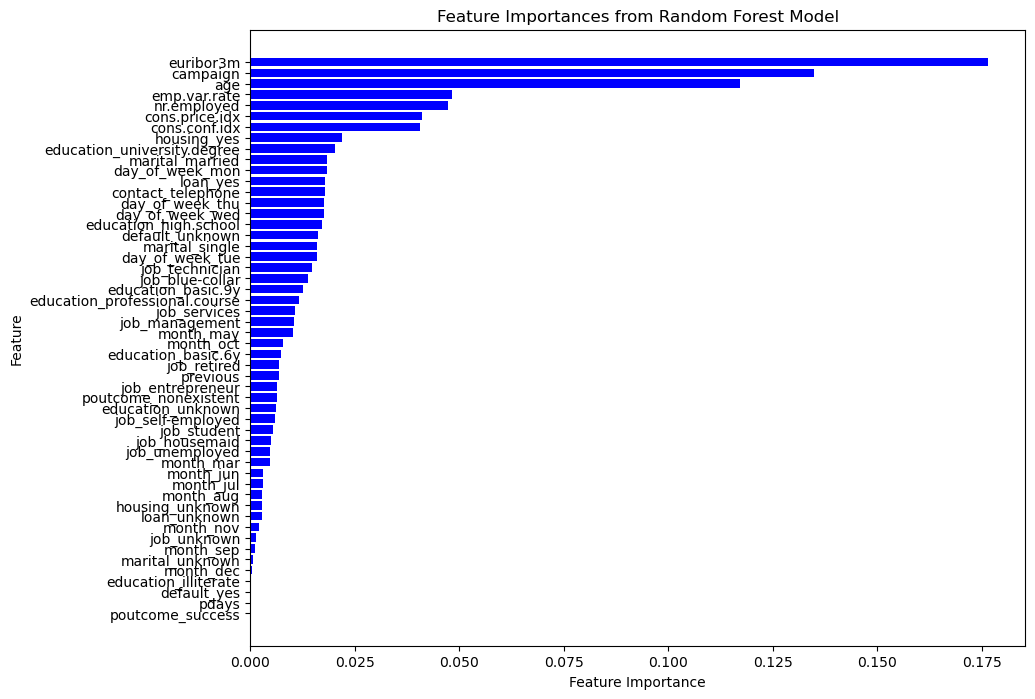

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Analyzing Feature Importance
feature_importances = clf.feature_importances_
feature_names = X_train.columns

# Sorting the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plotting the feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

In [26]:
import shap

# Create a sample of the training data for SHAP analysis
# sample_size = 1000  # Adjust this size based on your system's capabilities
# X_train_sample = X_train[:sample_size]
# y_train_sample = y_train[:sample_size]

# Convert boolean columns to int (0, 1)
X_train = X_train.astype(int)
X_val = X_val.astype(int)
X_test = X_test.astype(int)

# Initialize the SHAP explainer
explainer = shap.Explainer(clf, X_train)

# Calculate SHAP values for the sample
shap_values = explainer(X_val)

100%|===================| 20582/20600 [12:18<00:00]        

In [36]:
print(shap_values.shape)
print(X_val.shape)

(10300, 52, 2)
(10300, 52)


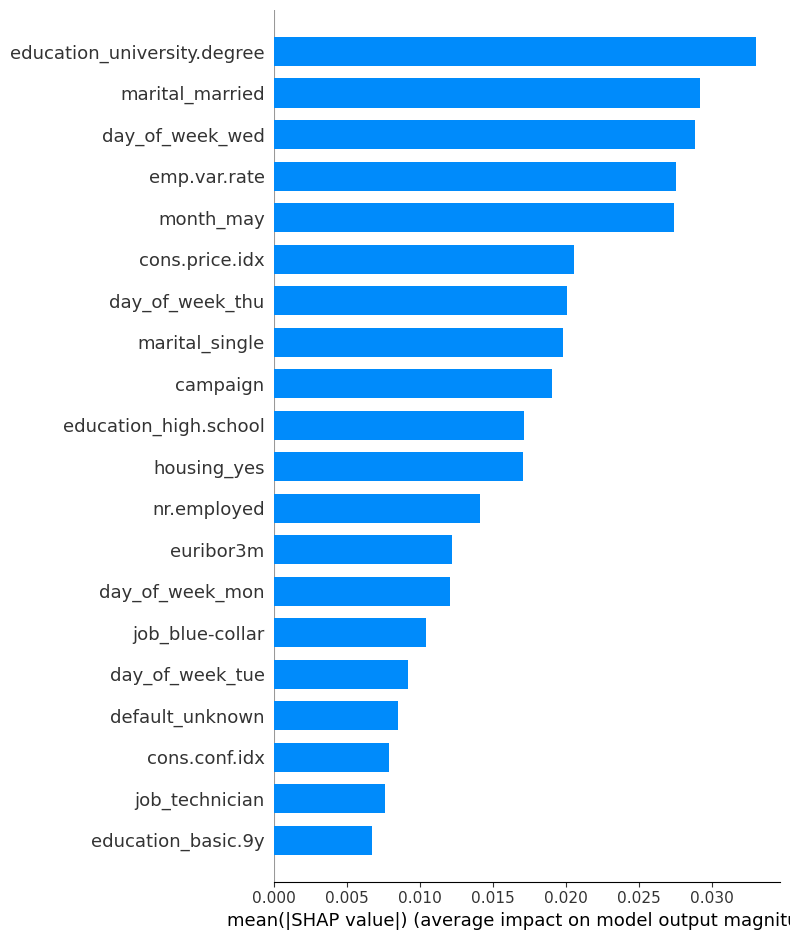

In [38]:
# Select the SHAP values for the positive class (index 1)
shap_values_class = shap_values[:, :, 1]

# Plotting SHAP Summary Plot as a Bar Plot
shap.summary_plot(shap_values_class, features=X_val, feature_names=X_val.columns, plot_type='bar')

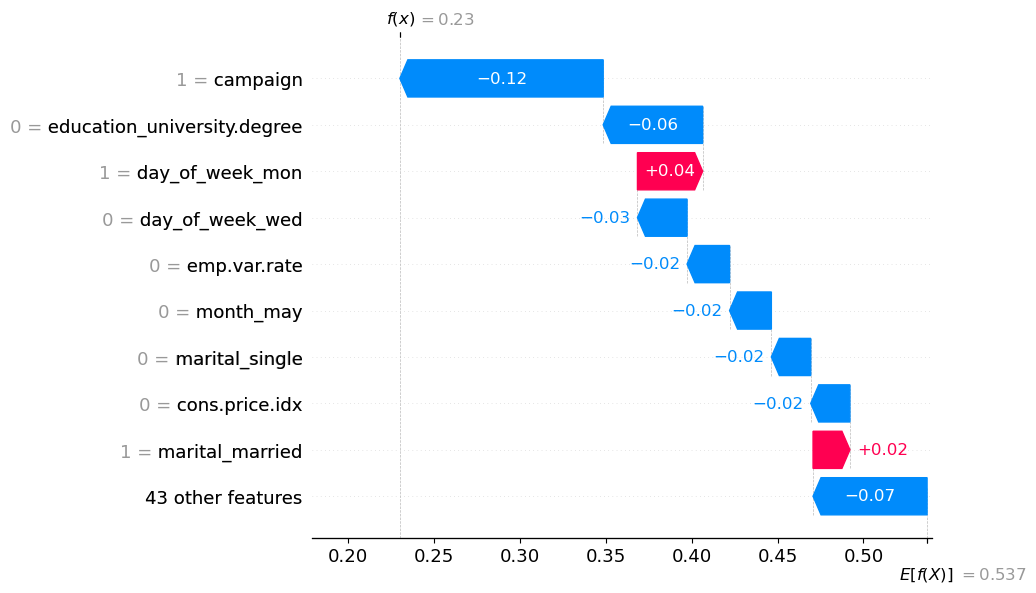

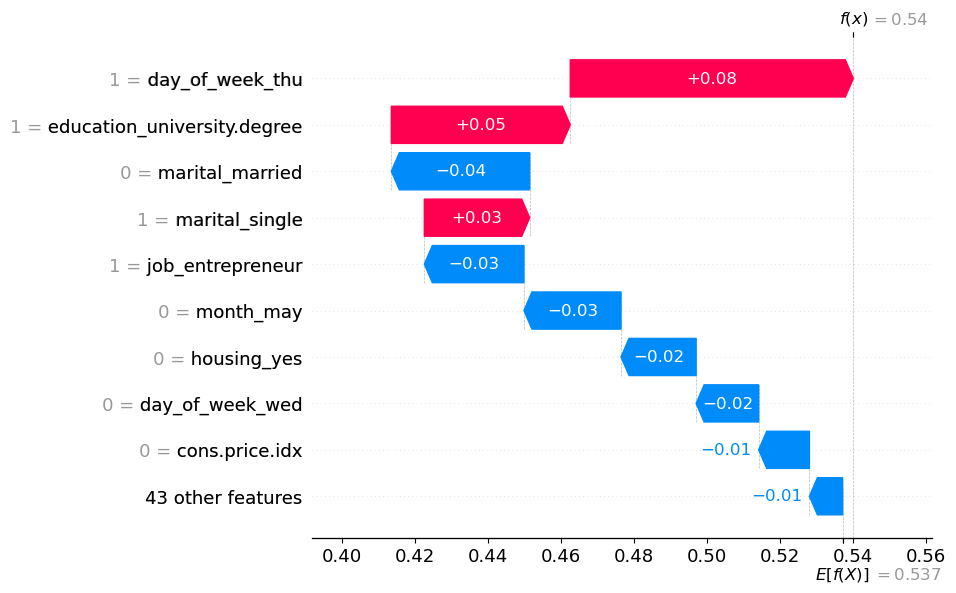

In [62]:
# SHAP analysis for observation #4 in the validation set
shap.plots.waterfall(shap_values[3, :, 1])

# SHAP analysis for observation #20 in the validation set
shap.plots.waterfall(shap_values[19, :, 1])

##### SVM Model

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train an SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.9175768166593855
Validation Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.87      0.91      6769
        True       0.88      0.97      0.92      6965

    accuracy                           0.92     13734
   macro avg       0.92      0.92      0.92     13734
weighted avg       0.92      0.92      0.92     13734

Validation Confusion Matrix:
 [[5862  907]
 [ 225 6740]]


In [22]:
# Make predictions on the test set
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

Test Accuracy: 0.9159749526722004
Test Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.86      0.91      6814
        True       0.88      0.97      0.92      6920

    accuracy                           0.92     13734
   macro avg       0.92      0.92      0.92     13734
weighted avg       0.92      0.92      0.92     13734

Test Confusion Matrix:
 [[5882  932]
 [ 222 6698]]
